#TASK1
Prepare Depth Estimation dataset, prepare also plot function that shows inputs and targets in pairs. Note that target data is stored in numpy format because the depth information is in mm. The maximum range of the data is 10000, so we normalize the original data by dividing it by 10000. You need to define such a custom transform. Search how to do that and implement it in your dataset.

NYU dataset
https://drive.google.com/file/d/1LoAaHshy-TwMckp755hi7O2FwsWL2SKU/view?usp=share_link

In [1]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import numpy as np
import cv2
import torch
from PIL import Image


class NYUDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        images, masks = self.load_images_masks()
        self.images = images
        self.masks = masks

    def __len__(self):
        return min(len(self.images), len(self.masks))

    
    def load_images_masks(self):
        image_paths = self.img_labels.iloc[:, 0].to_list()
        image_paths = list(map(lambda p: os.path.join(self.img_dir, p), image_paths))
        mask_paths = self.img_labels.iloc[:, 1].to_list()
        mask_paths = list(map(lambda p: os.path.join(self.img_dir, p), mask_paths))

        images = list(tqdm(map(Image.open, image_paths), total=len(image_paths)))
        images_np = list(map(np.array, images))
        masks = list(tqdm(map(Image.open, mask_paths), total=len(mask_paths)))
        masks_np = list(map(np.array, masks))

        if self.transform:
            images_np = list(tqdm(map(self.transform, images_np), total=len(images_np)))
        
        if self.target_transform:
            masks_np = list(tqdm(map(self.target_transform, masks_np), total=len(masks_np)))

        images_tensors = list(map(torch.from_numpy, images_np))
        masks_tensors = list(map(torch.from_numpy, masks_np))

        return images_tensors, masks_tensors

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]


normalize_images = lambda image: cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
visual_mask_fn = np.vectorize(lambda x: np.array(x) / 10000)


train_ds = NYUDataset(annotations_file='../data/nyu_samples/nyu2_test.csv', 
    img_dir='../data/nyu_samples/nyu2_test',
    transform=normalize_images,
    target_transform=visual_mask_fn
    )
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
test_image, test_mask = train_ds[0]

100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


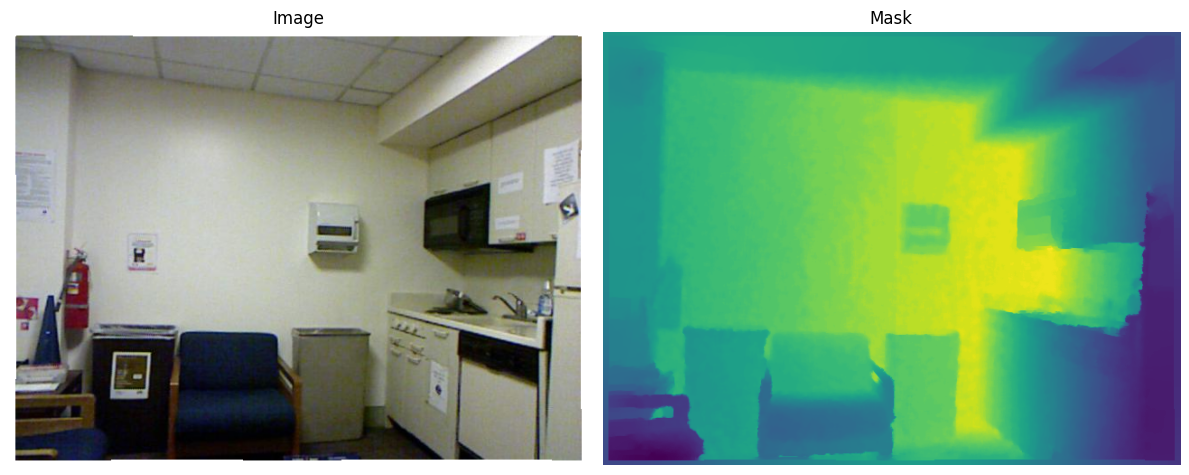

In [3]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(test_image)
axs[0].set_title('Image')
axs[0].axis('off')

axs[1].imshow(test_mask)
axs[1].set_title('Mask')
axs[1].axis('off')

plt.tight_layout()
plt.show()

Here you can find reference of the EfficientDet architecture.

https://github.com/tristandb/EfficientDet-PyTorch

In [4]:
import torch.nn as nn
import torch
import math

class BiFPN(nn.Module):
    def __init__(self,  fpn_sizes):
        super(BiFPN, self).__init__()

        P3_channels, P4_channels, P5_channels, P6_channels, P7_channels = fpn_sizes
        self.W_bifpn = 64

        #self.p6_td_conv  = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_td_conv  = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p6_td_conv_2  = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_td_act   = nn.ReLU()
        self.p6_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_td_w1    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_td_w2    = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p5_td_conv  = nn.Conv2d(P5_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p5_td_conv_2  = nn.Conv2d(self.W_bifpn,self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p5_td_act   = nn.ReLU()
        self.p5_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_td_w1    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_td_w2    = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p4_td_conv  = nn.Conv2d(P4_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p4_td_conv_2  = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p4_td_act   = nn.ReLU()
        self.p4_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_td_w1    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_td_w2    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_upsample   = nn.Upsample(scale_factor=2, mode='nearest')


        self.p3_out_conv = nn.Conv2d(P3_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p3_out_conv_2 = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p3_out_act   = nn.ReLU()
        self.p3_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p3_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_upsample  = nn.Upsample(scale_factor=2, mode='nearest')

        #self.p4_out_conv = nn.Conv2d(P4_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p4_out_conv = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p4_out_act   = nn.ReLU()
        self.p4_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w3   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_downsample= nn.MaxPool2d(kernel_size=2)

        #self.p5_out_conv = nn.Conv2d(P5_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p5_out_conv = nn.Conv2d(self.W_bifpn,self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p5_out_act   = nn.ReLU()
        self.p5_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w3   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_downsample= nn.MaxPool2d(kernel_size=2)

        #self.p6_out_conv = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p6_out_conv = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_out_act   = nn.ReLU()
        self.p6_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w3   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        #self.p4_downsample= nn.MaxPool2d(kernel_size=2)


        self.p7_out_conv = nn.Conv2d(P7_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p7_out_conv_2 = nn.Conv2d(self.W_bifpn,self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p7_out_act  = nn.ReLU()
        self.p7_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p7_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p7_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)


    def forward(self, inputs):
        epsilon = 0.0001
        P3, P4, P5, P6, P7 = inputs
        #print ("Input::", P3.shape, P4.shape, P5.shape, P6.shape, P7.shape)
        #P6_td = self.p6_td_conv((self.p6_td_w1 * P6 ) /
        #                         (self.p6_td_w1 + epsilon))

        P7_td  = self.p7_out_conv(P7)

        P6_td_inp = self.p6_td_conv(P6)
        P6_td = self.p6_td_conv_2((self.p6_td_w1 * P6_td_inp + self.p6_td_w2 * P7_td) /
                                 (self.p6_td_w1 + self.p6_td_w2 + epsilon))
        #P6_td = self.p6_td_conv_2(P6_td_inp)
        P6_td = self.p6_td_act(P6_td)
        P6_td = self.p6_td_conv_bn(P6_td)


        P5_td_inp = self.p5_td_conv(P5)
        #print (P5_td_inp.shape, P6_td.shape)
        P5_td = self.p5_td_conv_2((self.p5_td_w1 * P5_td_inp + self.p5_td_w2 * P6_td) /
                                 (self.p5_td_w1 + self.p5_td_w2 + epsilon))
        P5_td = self.p5_td_act(P5_td)
        P5_td = self.p5_td_conv_bn(P5_td)

        #print (P4.shape, P5_td.shape)
        P4_td_inp = self.p4_td_conv(P4)
        P4_td = self.p4_td_conv_2((self.p4_td_w1 * P4_td_inp + self.p4_td_w2 * self.p5_upsample(P5_td)) /
                                 (self.p4_td_w1 + self.p4_td_w2 + epsilon))
        P4_td = self.p4_td_act(P4_td)
        P4_td = self.p4_td_conv_bn(P4_td)


        P3_td  = self.p3_out_conv(P3)
        P3_out = self.p3_out_conv_2((self.p3_out_w1 * P3_td + self.p3_out_w2 * self.p4_upsample(P4_td)) /
                                 (self.p3_out_w1 + self.p3_out_w2 + epsilon))
        P3_out = self.p3_out_act(P3_out)
        P3_out = self.p3_out_conv_bn(P3_out)

        #print (P4_td.shape, P3_out.shape)

        P4_out = self.p4_out_conv((self.p4_out_w1 * P4_td_inp  + self.p4_out_w2 * P4_td + self.p4_out_w3 * self.p3_downsample(P3_out) )
                                    / (self.p4_out_w1 + self.p4_out_w2 + self.p4_out_w3 + epsilon))
        P4_out = self.p4_out_act(P4_out)
        P4_out = self.p4_out_conv_bn(P4_out)


        P5_out = self.p5_out_conv(( self.p5_out_w1 * P5_td_inp + self.p5_out_w2 * P5_td + self.p5_out_w3 * self.p4_downsample(P4_out) )
                                    / (self.p5_out_w2 + self.p5_out_w3 + epsilon))
        P5_out = self.p5_out_act(P5_out)
        P5_out = self.p5_out_conv_bn(P5_out)


        P6_out = self.p6_out_conv((self.p6_out_w1 * P6_td_inp + self.p6_out_w2 * P6_td + self.p6_out_w3 * (P5_out) )
                                    / (self.p6_out_w1 + self.p6_out_w2 + self.p6_out_w3 + epsilon))
        P6_out = self.p6_out_act(P6_out)
        P6_out = self.p6_out_conv_bn(P6_out)


        P7_out = self.p7_out_conv_2((self.p7_out_w1 * P7_td + self.p7_out_w2 * P6_out) /
                                 (self.p7_out_w1 + self.p7_out_w2 + epsilon))
        P7_out = self.p7_out_act(P7_out)
        P7_out = self.p7_out_conv_bn(P7_out)


        return [P3_out, P4_out, P5_out, P6_out, P7_out]

In [5]:
fpn = BiFPN([40, 112, 192, 192, 1280])

c1 = torch.randn([1, 40, 64, 64])
c2 = torch.randn([1, 112, 32, 32])
c3 = torch.randn([1, 192, 16, 16])
c4 = torch.randn([1, 192, 16, 16])
c5 = torch.randn([1, 1280, 16, 16])

In [6]:
output=fpn([c1,c2,c3,c4,c5])

Above is an illustration how to use BiFPN node. But note that BiFPN can be stacked in order to process multi-resolution information.

#TASK2
Below you can find an example how to use a pretrained resnet18 as backbone. Now use this backbone feature outputs, connect them to 5 BiFPN blocks. Write everything in class ResnetBiFPN(). Then create class EfficientBiFPN using efficientb0 example shown at last.

In [7]:
import torchvision
resnet = torchvision.models.resnet18(pretrained=True)

/home/agorski/Desktop/projects/ENNCA-agorski/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/agorski/Desktop/projects/ENNCA-agorski/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.layer1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer2 = resnet.layer1
        self.layer3 = resnet.layer2
        self.layer4 = resnet.layer3
        self.layer5 = resnet.layer4
    def get_features(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        return x1,x2,x3,x4,x5

In [10]:
import torch.nn.functional as F
resnet_encoder = ResNet()
bifpn1 = BiFPN([64, 64, 128, 256, 512])
bifpn2 = BiFPN([64, 64, 64, 64, 64])
bifpn3 = BiFPN([64, 64, 64, 64, 64])
bifpn4 = BiFPN([64, 64, 64, 64, 64])
bifpn5 = BiFPN([64, 64, 64, 64, 64])

In [11]:
for x, y in train_dl:
    x = x.reshape((x.shape[0], x.shape[3], x.shape[1], x.shape[2]))
    x1,x2,x3,x4,x5 = resnet_encoder.get_features(x)
    print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
    x1 = F.interpolate(x1, size=(120, 120), mode='bilinear')
    x2 = F.interpolate(x2, size=(60, 60), mode='bilinear')
    x3 = F.interpolate(x3, size=(30, 30), mode='bilinear')
    x4 = F.interpolate(x4, size=(30, 30), mode='bilinear')
    x5 = F.interpolate(x5, size=(30, 30), mode='bilinear')
    x1,x2,x3,x4,x5 = bifpn1.forward([x1, x2, x3, x4, x5])
    x1,x2,x3,x4,x5 = bifpn2.forward([x1, x2, x3, x4, x5])
    x1,x2,x3,x4,x5 = bifpn2.forward([x1, x2, x3, x4, x5])
    x1,x2,x3,x4,x5 = bifpn3.forward([x1, x2, x3, x4, x5])
    x1,x2,x3,x4,x5 = bifpn5.forward([x1, x2, x3, x4, x5])
    print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
    break

torch.Size([4, 64, 120, 160]) torch.Size([4, 64, 120, 160]) torch.Size([4, 128, 60, 80]) torch.Size([4, 256, 30, 40]) torch.Size([4, 512, 15, 20])
torch.Size([4, 64, 120, 120]) torch.Size([4, 64, 60, 60]) torch.Size([4, 64, 30, 30]) torch.Size([4, 64, 30, 30]) torch.Size([4, 64, 30, 30])


In [12]:
class ResNetBiFPN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet_encoder = ResNet()
        self.bifpn1 = BiFPN([64, 64, 128, 256, 512])
        self.bifpn2 = BiFPN([64, 64, 64, 64, 64])
        self.bifpn3 = BiFPN([64, 64, 64, 64, 64])
        self.bifpn4 = BiFPN([64, 64, 64, 64, 64])
        self.bifpn5 = BiFPN([64, 64, 64, 64, 64])
    
    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[3], x.shape[1], x.shape[2]))
        x1,x2,x3,x4,x5 = resnet_encoder.get_features(x)
        x1 = F.interpolate(x1, size=(120, 120), mode='bilinear')
        x2 = F.interpolate(x2, size=(60, 60), mode='bilinear')
        x3 = F.interpolate(x3, size=(30, 30), mode='bilinear')
        x4 = F.interpolate(x4, size=(30, 30), mode='bilinear')
        x5 = F.interpolate(x5, size=(30, 30), mode='bilinear')
        print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
        x1,x2,x3,x4,x5 = self.bifpn1.forward([x1, x2, x3, x4, x5])
        x1,x2,x3,x4,x5 = self.bifpn2.forward([x1, x2, x3, x4, x5])
        x1,x2,x3,x4,x5 = self.bifpn3.forward([x1, x2, x3, x4, x5])
        x1,x2,x3,x4,x5 = self.bifpn4.forward([x1, x2, x3, x4, x5])
        x1,x2,x3,x4,x5 = self.bifpn5.forward([x1, x2, x3, x4, x5])
        return x1, x2, x3, x4, x5


In [13]:
resnetbifpn_model = ResNetBiFPN()
for x, y in train_dl:
    x1, x2, x3, x4, x5 = resnetbifpn_model.forward(x)
    print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
    break


torch.Size([4, 64, 120, 120]) torch.Size([4, 64, 60, 60]) torch.Size([4, 128, 30, 30]) torch.Size([4, 256, 30, 30]) torch.Size([4, 512, 30, 30])
torch.Size([4, 64, 120, 120]) torch.Size([4, 64, 60, 60]) torch.Size([4, 64, 30, 30]) torch.Size([4, 64, 30, 30]) torch.Size([4, 64, 30, 30])


In [17]:
# import torchvision
# encoder = torchvision.models.efficientnet_b0(pretrained=True)
# encoder.classifier = torch.nn.Identity()
# print(encoder.classifier)
# print(encoder.features[-1])

In [18]:
# print(dir(encoder))

In [19]:
# for x, y in train_dl:
#     x = x.reshape((x.shape[0], x.shape[3], x.shape[1], x.shape[2]))
#     x = encoder(x)
#     print(x.shape)
#     x = encoder(x)
#     print(x.shape)

#     break